In [1]:
#%load_ext lab_black
import pandas as pd
import numpy as np
import scipy
import statsmodels.api as sm
from statsmodels.sandbox.regression import gmm
import matplotlib.pyplot as plt
import seaborn as sns

#Linear City Model

In [2]:
def drawConsumer (register, L:int=1, fixLocation=None):
    """L: number of goods"""
    c = {
        "id": register["consumerId"]+1, 
        "type": "consumer",
        "wealth": 2 + np.random.rand()*2,
        "talent": 2 + np.random.rand()*2,
        "taste": np.random.rand(L),
        "mc_transport": 0.025,
        'supplierId': None,
        'location': fixLocation
    }
    register["consumers"][c["id"]] = c
    register["consumerId"] += 1
    return(c)

In [3]:
def drawFirm (register, L:int=1, fixLocation=None):
    f = {
        "id": register["firmId"]+1, 
        "type": "firm",
        "mc": np.random.rand()/4,
        "good": np.random.randint(0,L),
        'clients': set(),
        'location': fixLocation,
    }
    register["firms"][f["id"]] = f
    register["firmId"] += 1
    return(f)

In [4]:
def floorCost (lvl: int):
    """returns cost for moving into floor lvl x"""
    cost = 0.1 + lvl ** 1.2 / 10
    return(cost)

In [5]:
list(map(lambda x: round(floorCost(x),2), range(10)))

[0.1, 0.2, 0.33, 0.47, 0.63, 0.79, 0.96, 1.13, 1.31, 1.5]

In [6]:
def consumerValue(consumer, firm):
    value = consumer["taste"][firm["good"]] * consumer["wealth"]
    value -= firm["mc"]
    value -= consumer["mc_transport"] * abs(consumer["location"] - firm["location"]) 
    return(value)
# 

In [7]:

def returnMaxIndex (numbers: list):
    """Return maximum index. If maximum is not unique, choose randomly among maxima."""
    # find all choice options with best value
    numberIsMax = [x == max(numbers) for x in numbers]
    # randomly choose one of them and return index
    maxInd = [c for (c, m) in zip(range(len(numberIsMax)), numberIsMax) if m][np.random.randint(0, sum(numberIsMax))]
    return maxInd
# 

In [8]:
def chooseSupplier (register:dict, consumer:dict):
    # consumer location must be given
    supplierId = consumer["supplierId"]
    currentValue = -100

    for firmId in register["firms"].keys():
        firm = register["firms"][firmId]
        if(firm["location"] != None):
            if(consumerValue(consumer, firm)>currentValue):
                supplierId = firm["id"]
                currentValue = consumerValue(consumer, firm)

    return supplierId
# 

In [9]:
def assignToFirm(register:dict, consumer:dict, firmId:str): 
    if(consumer["supplierId"] != None and consumer["supplierId"] != firmId):
        register["firms"][consumer["supplierId"]]["clients"].discard(consumer["id"])

    consumer["supplierId"] = firmId 

    if not consumer["id"] in register["firms"][firmId]["clients"]:
        register["firms"][firmId]["clients"].add(consumer["id"]) 

#

In [10]:
def settleConsumer (city:list, register:dict, consumer:dict, relocate:bool=False):
    if(relocate):
        city[consumer["location"]].remove(consumer)
        register["firms"][consumer["supplierId"]]["clients"].discard(consumer["id"])


    # give a value to each possible settlement position
    locationValues = list(map(lambda x: -floorCost(len(x)), city))
    locationSuppliers = [consumer["supplierId"]]*len(city)
    for locationInd, location in enumerate(city):
        consumer["location"] = locationInd
        locationSupplier = register["firms"][chooseSupplier(register, consumer)]
        locationValues[locationInd] = consumerValue(consumer, locationSupplier) - floorCost(len(location))
        locationSuppliers[locationInd] = locationSupplier['id']
        
    if(max(locationValues)<0):
        print('Consumer wont settle in city', max(locationValues)<0)
        #register["consumers"].remove(consumer)
    else:
        locationInd = returnMaxIndex(locationValues)
        consumer['location'] = locationInd
        assignToFirm(register, consumer, locationSuppliers[locationInd])
        city[locationInd].append(consumer)
#

In [11]:
def settleFirm(city:list, register, firm:dict, relocate:bool=False): 

    if(relocate):
        city[firm["location"]].remove(firm)
        for client in firm["clients"]:
            firm = chooseSupplier(register, client)
            assignToFirm(register, client, firm["id"])


    locationValues = list(map(lambda x: -floorCost(len(x)), city)) 
    locationClients = [[]]*len(city)

    for locationInd, location in enumerate(city):
        firm["location"] = locationInd
        for consumerId in register["consumers"].keys():
            consumer = register["consumers"][consumerId]
            
            if( consumer["supplierId"] == None or consumerValue(consumer, register["firms"][consumer["supplierId"]] ) < consumerValue(consumer, firm) ):
                        locationValues[locationInd] += max(0, consumerValue(consumer, firm) - firm["mc"]) # how is welfare shared 
                        locationClients[locationInd].append(consumer["id"])

    # locate firm at maximum location index
    locationInd = returnMaxIndex(locationValues)
    firm["location"] = locationInd
    for clientId in locationClients[locationInd]:
        client = register["consumers"][clientId]
        if(client["supplierId"] in register["firms"].keys()):
            register["firms"][client["supplierId"]]["clients"].discard(clientId)
        client["supplierId"] = firm["id"]

    city[locationInd].append(firm) 

#

In [12]:
list(list(range(0)))

[]

In [13]:
def createNewCity (L, size:int=100, firmPositions:list=[range(0)], consumerPositons:list=[range(0)]):
    register = {
        "consumers": {},
        "firms" : {},
        "consumerId": 0,
        "firmId": 0,
    }

    city = list(map(lambda x: [], [1]*size))
    
    for positions in firmPositions:
        positions = list(positions)
        for pos in positions:
            city[pos].append(drawFirm(register, L, pos))
            
    for positions in consumerPositons:
        positions = list(positions)
        for pos in positions:
            city[pos].append(drawConsumer(register, L, pos))

    return (city, register)

In [14]:
(city, register) = createNewCity(1,10, [],[range(4,5)])
register

{'consumers': {1: {'id': 1,
   'type': 'consumer',
   'wealth': 3.7844385760603028,
   'talent': 2.3189691880380026,
   'taste': array([0.72819327]),
   'mc_transport': 0.025,
   'supplierId': None,
   'location': 4}},
 'firms': {},
 'consumerId': 1,
 'firmId': 0}

In [22]:
len()

100

Consumer wont settle in city True
Consumer wont settle in city True


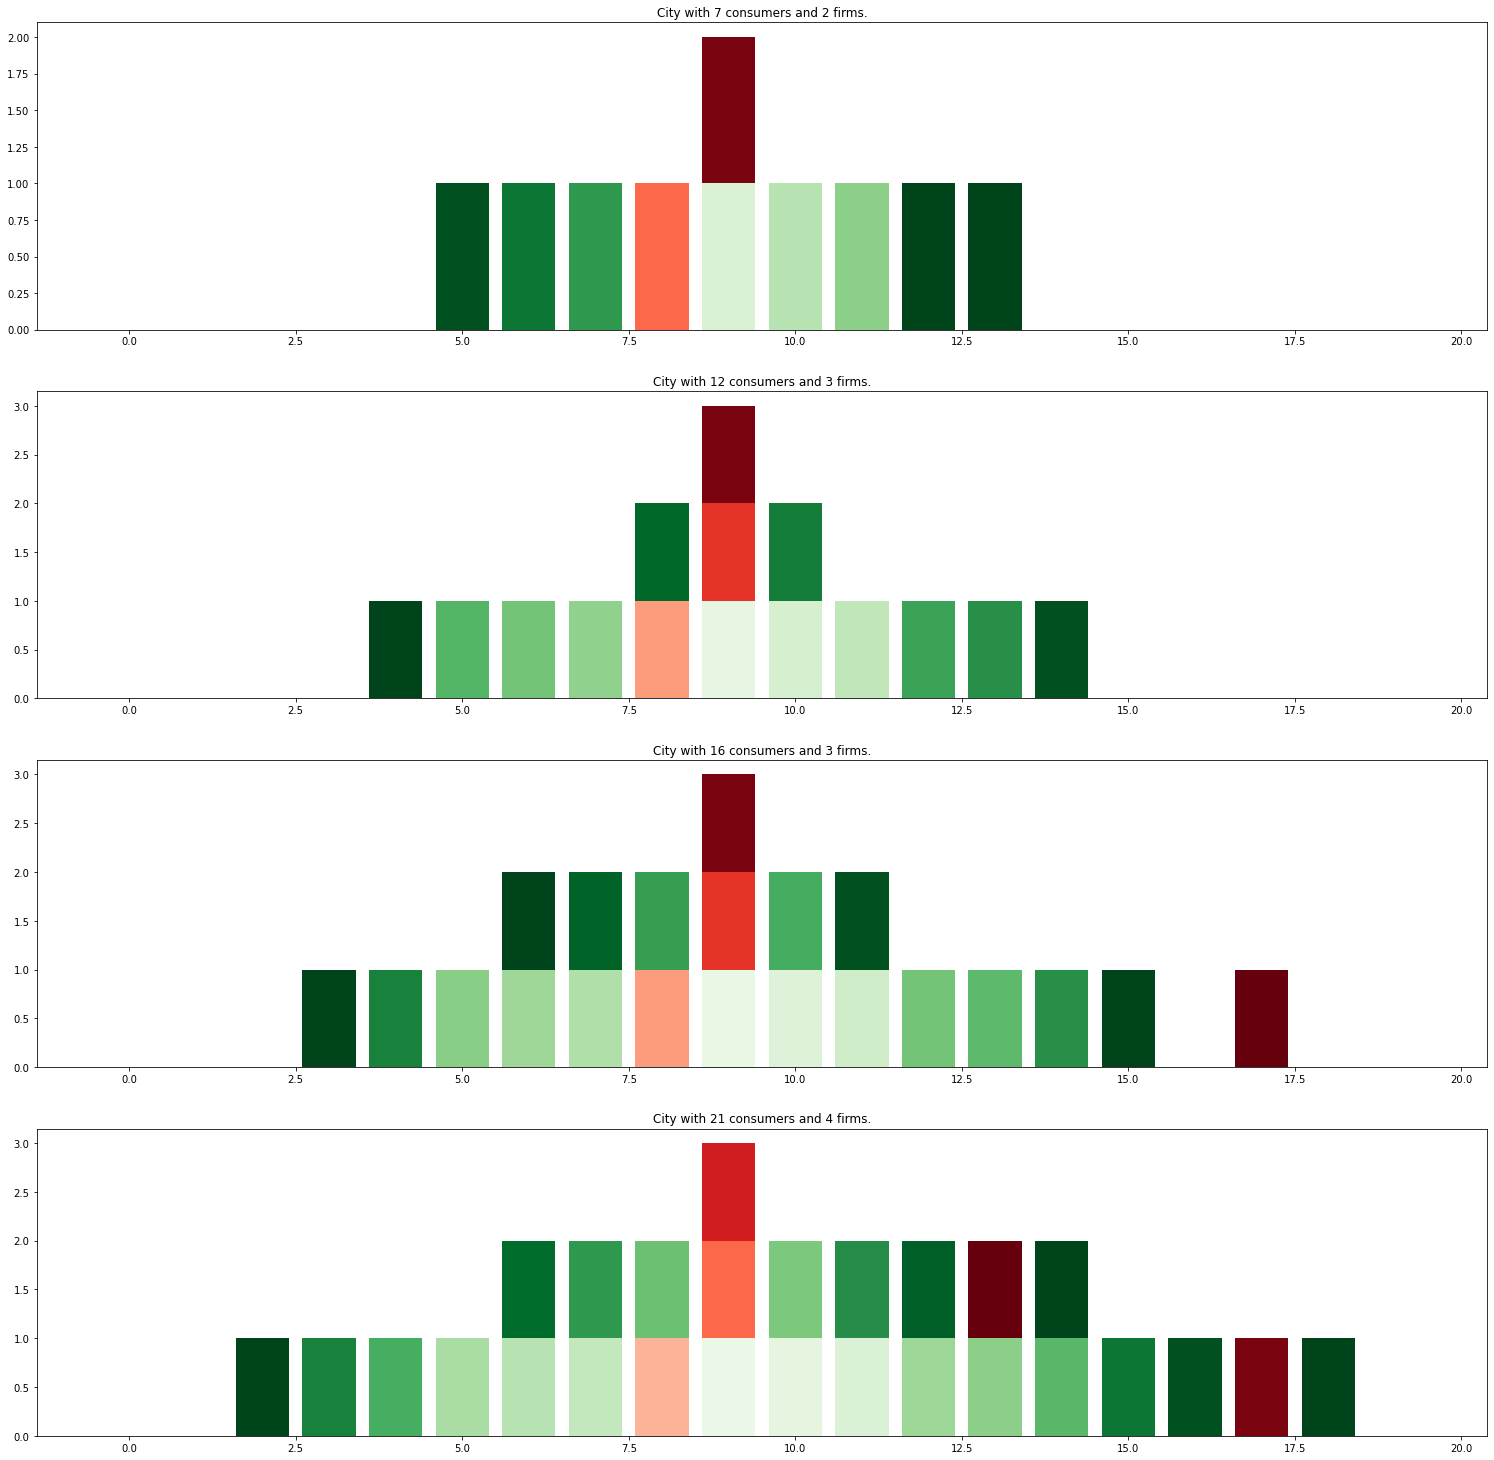

In [27]:
# number of differntiated goods
params = {
    "L":1,
    "citysize": 20,
    "firmPostions_start": [],
    "consumerPositons_start": [range(9,12)],
    "max_pop": 20,
    "firm_to_pop_ratio": 1/5,
    "n_subplots": 4
}
# number of lots in linear city, maximum floor number

(city, register) = createNewCity(L=params["L"], size=params["citysize"], firmPositions=params["firmPostions_start"], consumerPositons=params["consumerPositons_start"])

fig, axs = plt.subplots(nrows=params["n_subplots"], ncols=1, figsize=(26,26))
plt.get_cmap('jet')
for i in range(params["max_pop"]+1):
    city_pop = sum(list(map(lambda l: len(list(filter(lambda p: p["type"]=="consumer", l))), city)))
    city_n_firms = sum(list(map(lambda l: len(list(filter(lambda p: p["type"]=="firm", l))), city)))
    if( (city_n_firms / city_pop) < params["firm_to_pop_ratio"] ):
        settleFirm(city, register, drawFirm(register, params["L"]))
        # print("added firm.")
        
    settleConsumer(city, register, drawConsumer(register, params["L"]))
    if(i in list(np.array(range(1,params["n_subplots"] + 1))*(params["max_pop"] / params["n_subplots"]))):
        ax = axs.flat[ int( (i // (params["max_pop"] / params["n_subplots"]) ) - 1) ]
        labels = range(len(city))
        for locInd, location in enumerate(city):
            for (floor, party) in enumerate(location):
                cn = int(10 + party["id"] * 236 / city_pop) if party["type"]=="consumer" else int(10 + party["id"] * 236 / city_n_firms) 
                
                clr = plt.cm.Greens(cn) if party["type"]=="consumer" else plt.cm.Reds(cn)
                ax.bar(labels, list([0]*(locInd)+[1]+[0]*(params["citysize"]-locInd-1)), bottom=floor, color=clr)    
        # n_firms = list(map(lambda l: len(list(filter(lambda p: p["type"]=="firm", l))),city))
        # n_consumers = list(map(lambda l: len(list(filter(lambda p: p["type"]=="consumer", l))),city))
        # #width = 0.35       # the width of the bars: can also be len(x) sequence
        
        # ax.bar(labels, n_firms, label='firms')
        # ax.bar(labels, n_consumers, bottom=n_firms, label='consumer')
        # ax.bar(labels, n_firms, label='firms')
        # ax.legend()
        # ax.set_ylabel('Scores')
        title = "City with " + str(city_pop) + " consumers and " + str(city_n_firms) + " firms."
        ax.set_title(title)

plt.show()


In [16]:
int((22 // (params["max_pop"] / params["n_subplots"]) ) - 1)

1

In [17]:
cmap = plt.cm.jet  # define the colormap
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]

In [18]:
plt.cm.Greens(250)

(0.0, 0.2918877354863514, 0.11633986928104575, 1.0)

In [19]:
plt.cm.Reds(256)

(0.403921568627451, 0.0, 0.05098039215686274, 1.0)